In [57]:
using PauliPropagation
using Random
using Optim
using Plots
#Random.seed!(43)
using ReverseDiff: GradientTape, gradient!, compile, gradient
using LinearAlgebra
using StatsBase 
using GLM
using DataFrames
using CSV
using LaTeXStrings

# Functions and Struct 

## Struct for QAOA ansatz


In [2]:
struct QAOA_ansatz
    #circuit details
    target_circuit::Vector{Gate}
    nqubits::Integer
    nlayers::Integer
    topology::Vector{Tuple{Int64, Int64}}
    repartition::Vector{Vector{Integer}}
end

In [3]:
function qaoa_setup(nqubits::Int, nlayers::Int, repartition::Vector{Vector{Int}}; topology=nothing)

    target_circuit, topology = tfimqaoacircuit(nqubits, nlayers; topology=topology)
    result = QAOA_ansatz(target_circuit, nqubits, nlayers,topology,repartition)
    return result
end

qaoa_setup (generic function with 1 method)

## Functions
- Circuit QAOA
- Parameter assignment for target and proposal circuits
- Loss function
- Gradient descent to optimize the VQA
- Target optimization function
- Initial MCMC circuit
- Proposal MCMC circuit
- MH algorithm
- Noisy expectation values

In [4]:
#QAOA circuit (Fig 10)
function tfimqaoacircuit(nqubits::Integer, nlayers::Integer; topology=nothing)
    circuit::Vector{Gate} = []

    if isnothing(topology)
        topology = bricklayertopology(nqubits;periodic=false) #chain with obc
    end

    for i in 1:nlayers
        rzzlayer!(circuit, topology)
        for qubit in 1:nqubits
            push!(circuit, CliffordGate(:S, qubit))
            push!(circuit, PauliRotation(:X, qubit, π/2)) # Fig 10: P=R_X(π/2)
            push!(circuit, PauliRotation(:Z, qubit))
            push!(circuit, PauliRotation(:X, qubit, π/2))
            push!(circuit, CliffordGate(:S, qubit))

        end
    end
    return circuit, topology
end

tfimqaoacircuit (generic function with 1 method)

In [5]:
function repartition_function_QAOA(nqubits, nlayers) #qaoa repartition function
    repartition = Vector{Vector{Int}}()
    idx = 1
    for i in 1:nlayers
            push!(repartition, collect(idx:idx + (nqubits - 2)))  # First nqubits-1 indices
            idx += (nqubits - 1)
            push!(repartition, collect(idx:idx + nqubits - 1))  # Next nqubits indices
            idx += nqubits
        
    end
    return repartition
end

repartition_function_QAOA (generic function with 1 method)

In [6]:
function constrain_params(thetas, repartition)
    for r in repartition
        for q in r
            thetas[q] = thetas[r[1]]
        end
    end
    return thetas
end

constrain_params (generic function with 1 method)

In [7]:
function fulllossfunction(thetas,proposal_circuit,ansatz::QAOA_ansatz;g = -2.0, max_freq=Inf, max_weight=Inf)

    type_of_coeff = eltype(thetas)
    H = PauliSum(ansatz.nqubits, type_of_coeff)
    for qind in 1:(ansatz.nqubits)
        add!(H, :X, qind, type_of_coeff(g))
    end
    for pair in ansatz.topology
        add!(H, [:Z, :Z], collect(pair), type_of_coeff(1.0))
    end
    
    wrapped_H = wrapcoefficients(H, PauliFreqTracker) #wrap to keep track of path splitting

    # We also need to run the in-place version with `!`, because by default we copy the Pauli sum
    wrapped_H = propagate!(proposal_circuit, wrapped_H, thetas; max_freq, max_weight);

    return overlapwithplus(wrapped_H)
end

fulllossfunction (generic function with 1 method)

In [8]:
function gd(thetas_init,closed_lossfunction, ansatz; repartition=nothing, eta=0.1, steps=100)
    
    if repartition == nothing
        repartition = ansatz.repartition
    end

    # some inputs and work buffer to play around with
    grad_array_compiled = similar(thetas_init);

    # pre-record a GradientTape for `gradsimulation` using inputs of length m with Float64 elements
    
    simulation_tape = GradientTape(closed_lossfunction, thetas_init)
    compiled_simulation_tape = compile(simulation_tape)

    opt_energy_gd = []
    thetas = thetas_init
    for i in 1:steps 
        gradient!(grad_array_compiled, simulation_tape, thetas)
        thetas .-= eta * grad_array_compiled
        constrain_params(thetas, repartition)
        opt_energy_gd = push!(opt_energy_gd, closed_lossfunction(thetas)/ansatz.nqubits)
    end

    return thetas, opt_energy_gd
end

gd (generic function with 1 method)

In [9]:
#repartition (defines which parameterized gates share the same values (a restriction of our ansatz) 
function repartition_function_proposal(nparams::Int, rzz_indices::Vector{Int}, rz_indices::Vector{Int})
    result = Vector{Vector{Int}}()
    tmp = []

    idx_rzz, idx_rz = 1, 1
    len_rzz, len_rz = length(rzz_indices), length(rz_indices)

    for i in 1:nparams
        if idx_rzz <= len_rzz && rzz_indices[idx_rzz] == i # && logical and
            push!(tmp, i)
            idx_rzz += 1
            if idx_rzz > len_rzz || rzz_indices[idx_rzz] != i + 1 # || logical or
                push!(result, tmp)
                tmp = []
            end
        elseif idx_rz <= len_rz && rz_indices[idx_rz] == i
            push!(tmp, i)
            idx_rz += 1
            if idx_rz > len_rz || rz_indices[idx_rz] != i + 1
                push!(result, tmp)
                tmp = []
            end
        end
    end
    return result
end

repartition_function_proposal (generic function with 1 method)

In [10]:
function target_optimization(ansatz; max_freq=30, max_weight=5, verbose = false)
    thetas_init = rand((2*ansatz.nqubits-1)*ansatz.nlayers) 
    thetas_init = constrain_params(thetas_init, ansatz.repartition)
    closed_lossfunction = let const_ansatz = ansatz, const_max_freq=max_freq, const_max_weight=max_weight
        # these are now all captured variables with known types and we return a function that only takes thetas s.t. ReverseDiff works
        # See also "closures"
        theta -> fulllossfunction(theta, ansatz.target_circuit, const_ansatz; max_freq=const_max_freq, max_weight=const_max_weight)
    end
    opt_thetas, opt_energy_gd = gd(thetas_init,closed_lossfunction,ansatz)
    if verbose
        println("Optimized thetas: ", opt_thetas)
        println("Optimized energy: ", opt_energy_gd[end])

        plot(opt_energy_gd)
        display(plot!(title = "Energy optimisation with GD", xlabel = "runs of GD", ylabel = "E/Q"))
    end

    return opt_thetas, opt_energy_gd
end

target_optimization (generic function with 1 method)

In [11]:
function initialize_mcmc_circuit(ansatz::QAOA_ansatz;num_gates_to_replace = nothing)
    
    if num_gates_to_replace == nothing
        num_gates_to_replace = div(ansatz.nqubits * ansatz.nlayers, 2)
    end
    # Choose nq*nl/2 random Pauli rotations to replace with Clifford R_Z(k_p π/2) gates.
    # The replacements are random for the whole circuit and don't repeat for each layer.

    # Get indices of Pauli rotations
    z_rot_indices = [i for i in eachindex(ansatz.target_circuit) if isa(ansatz.target_circuit[i], PauliRotation)]
    Random.shuffle!(z_rot_indices)
    indices_replaced = z_rot_indices[1:num_gates_to_replace]

    # Extract qubit indices for gates to be replaced
    qubits = [ansatz.target_circuit[i].qinds for i in indices_replaced]


    # Create a modified circuit
    new_circuit = copy(ansatz.target_circuit)

    # Replace selected R_Z rotations with Clifford R_Z(k_p π/2)
    for (j, i) in enumerate(indices_replaced)
        k_p = rand(0:3)  ### Randomly select k_p from {0,1,2,3} ( NO CLEAR INDICATION in the paper)
        if length(qubits[j]) == 1
            new_circuit[i] = PauliRotation(:Z, qubits[j], k_p * π/2)  # Replace with Clifford rotation
        else
            new_circuit[i] = PauliRotation([:Z, :Z], qubits[j], k_p * π/2)  # Replace with Clifford rotation
        end
    end

    return new_circuit, indices_replaced
end

initialize_mcmc_circuit (generic function with 1 method)

In [12]:
function proposal_tfimqaoacircuit(ansatz::QAOA_ansatz,current_circuit::Vector{Gate},current_replaced_indices::Vector{Int},target_thetas::Vector{Float64};npairs::Integer=ansatz.nqubits)    
    # Identify all Pauli Z rotations in the circuit (includes RZZ) (Pauli Z are only the non-Cifford's here)
    proposal_circuit = deepcopy(current_circuit)
    z_rot_indices = [i for i in eachindex(proposal_circuit) if isa(proposal_circuit[i], PauliRotation)]

    #println("Z rotation indices (Non-Cliffords): ", z_rot_indices)
    #println("Indices replaced (Frozen Z rotations (Cliffords)): ", current_replaced_indices)  
    # Ensure we have enough pairs
    #the length(current_replaced_indices) is exactly the number of gates to replace
    if length(current_replaced_indices) < npairs
        error("Not enough frozen Pauli rotations in the initialized MCMC circuit to select the value of pairs.")
    end

    # Shuffle and select n_p pairs
    Random.shuffle!(z_rot_indices)
    Random.shuffle!(current_replaced_indices)
    selected_pairs = [(z_rot_indices[i], current_replaced_indices[i]) for i in 1:npairs] 
    
    #println("Selected pairs of Cliff. and non-Clifford: ", selected_pairs) 
    #println("Circuit before replacement: ", proposal_circuit)

    function compute_distance(alpha, n)
        Pauli_z = [1 0; 0 -1]
        S_n = exp(-im * n * π / 2 * Pauli_z)
        Rz_alpha = exp(-im * alpha * Pauli_z/2)
        return LinearAlgebra.norm(Rz_alpha - S_n)
    end
    
    # Define probability distribution function
    function sample_kn(alpha)
        sigma = 0.5
        n_vals =LinRange(0,7,8) # limit n values (they repeat after 2 pi)
        distances = [compute_distance(alpha, n) for n in n_vals]
        weights = exp.(-distances.^2 ./ sigma^2)
        probs = ProbabilityWeights(weights ./ sum(weights)) 

        return first(StatsBase.sample(n_vals,probs,1))  # Sample from the distribution (using StatsBase)
    end

    #the thetas are the optimized ones from the target circuit
    function get_alpha(qubits, target_thetas, repartition)
        # allows to break from nested loops
        function find_alpha()
            found = false
            alpha = 0
            for k in qubits
                for (i, r) in enumerate(repartition)
                    for q in r
                        if q==k
                            alpha = target_thetas[i]
                            found = true
                            return alpha, found
                        end
                    end
                end
            end
            return alpha, found
        end

        alpha, found = find_alpha()
        if !found
            throw("qubits $qubits not found in repartition")
        else
            return alpha
        end
    end

    #choose left element of each pair and replace with Clifford gate S^n,sample n
    for (i, j) in selected_pairs
        qubits = proposal_circuit[i].qinds
        
        alpha = get_alpha(qubits, target_thetas, ansatz.repartition)
        
        k_p = sample_kn(alpha)
        
        if length(qubits) == 1
            proposal_circuit[i] = PauliRotation(:Z, qubits, k_p * π/2)  # Replace with Clifford rotation
        else
            proposal_circuit[i] = PauliRotation([:Z, :Z], qubits, k_p * π/2)  # Replace with Clifford rotation
        end
    end


    #then reset the right element (Clifford, FrozenGate[PauliRotation]]) to the one of the target circuit
    for (i, j) in selected_pairs 
        qubits = proposal_circuit[j].gate.qinds
        proposal_circuit[j] = ansatz.target_circuit[j] 
    end
    
    #update the replaced indices
    updated_replaced_indices = setdiff(current_replaced_indices, [j for (_, j) in selected_pairs])
    append!(updated_replaced_indices, [i for (i, _) in selected_pairs])

    return proposal_circuit, updated_replaced_indices
end

proposal_tfimqaoacircuit (generic function with 1 method)

In [13]:
function MCMC(ansatz::QAOA_ansatz,thetas::Vector{Float64};num_gates_to_replace = nothing, num_acc_samples::Integer = 10,burn_in_samples =50,n_sweeps::Integer =5, npairs::Integer=ansatz.nqubits, x_sigma::Float64=0.1,x_0::Float64 =-2.1, max_freq=30, max_weight=5,verbose=false)
    
    #init the MCMC (we set a certain number of Pauli rotations to Clifford gates)
    initial_circuit, initial_replaced_indices = initialize_mcmc_circuit(ansatz;num_gates_to_replace = num_gates_to_replace)
    n_accepted = 0 
    
    current_circuit = deepcopy(initial_circuit)
    current_replaced_indices = deepcopy(initial_replaced_indices)
    
    acceptance_rates = Vector{Float64}()
    acc_samples = Vector{Vector{Gate}}()
    exact_energies = Vector{Float64}()
    #acc_ratio_list = Vector{Float64}()
    repartition_list = []
    i = 0

    while n_accepted<num_acc_samples 
        i += 1
        proposal_circuit, updated_replaced_indices = proposal_tfimqaoacircuit(ansatz, current_circuit, current_replaced_indices,thetas; npairs) 
        rzz_indices = getparameterindices(proposal_circuit, PauliRotation, [:Z, :Z])
        rz_indices = getparameterindices(proposal_circuit, PauliRotation, [:Z])
        nparams = countparameters(proposal_circuit)
        repartition = repartition_function_proposal(nparams, rzz_indices, rz_indices)
        if num_gates_to_replace == nothing
            num_gates_to_replace = div(ansatz.nqubits * ansatz.nlayers, 2)
        end

        thetas_init_prop = rand((2*ansatz.nqubits-1)*ansatz.nlayers-num_gates_to_replace) #need integer division! this number of replacements is hard coded in initialize_mcmc_circuit
        thetas_init_prop = constrain_params(thetas_init_prop, repartition)

        closed_lossfunction = let const_prop_circuit = proposal_circuit ,const_ansatz = ansatz, const_max_freq=max_freq, const_max_weight=max_weight 
            # these are now all captured variables with known types and we return a function that only takes thetas s.t. ReverseDiff works
            # See also "closures"
            theta -> fulllossfunction(theta, const_prop_circuit,const_ansatz; max_freq=const_max_freq, max_weight=const_max_weight)
        end

        #we need to specify we are using a different repartition now!
        x_exact = gd(thetas_init_prop,closed_lossfunction,ansatz;repartition = repartition)[2][end]
        #acceptance ratio
        acc_ratio = min(1,exp(-(x_exact-x_0)^2/(x_sigma^2)))
        #push!(acc_ratio_list, acc_ratio)

        if rand() < acc_ratio
            current_circuit = deepcopy(proposal_circuit)
            current_replaced_indices = deepcopy(updated_replaced_indices)

            #only record after burn-in time
            if i > burn_in_samples
                if n_sweeps == 0
                    n_accepted += 1
                    
                    if verbose
                        println("accepted")
                    end 

                    acceptance_rate = n_accepted/(i-burn_in_samples)
                    push!(acc_samples, current_circuit)
                    push!(exact_energies, x_exact)
                    push!(repartition_list, repartition)
                    push!(acceptance_rates,acceptance_rate)
                elseif i%n_sweeps == 0
                    n_accepted += 1
                    acceptance_rate = n_accepted/(i-burn_in_samples)
                    push!(acc_samples, current_circuit)
                    push!(exact_energies, x_exact)
                    push!(repartition_list, repartition)
                    push!(acceptance_rates,acceptance_rate)
                end
            end
        end
    
    end

return acc_samples,exact_energies,acceptance_rates,repartition_list,i

end

MCMC (generic function with 1 method)

In [14]:
function noisy_expectation_values(ansatz, acc_samples, repartition;num_gates_to_replace = nothing, max_freq = 30, max_weight = 5,depol_strength = 0.05, dephase_strength = 0.05, target = false)

    if num_gates_to_replace == nothing
        num_gates_to_replace = div(ansatz.nqubits * ansatz.nlayers, 2)
    end
    #define the noise layer and add to every circuit
    depol_noise_layer = [DepolarizingNoise(qind, depol_strength ) for qind in 1:ansatz.nqubits];

    dephase_noise_layer = [DephasingNoise(qind, dephase_strength) for qind in 1:ansatz.nqubits];
    
    noisy_acc_samples = deepcopy(acc_samples)
    for i in 1:length(noisy_acc_samples)
        append!(noisy_acc_samples[i], depol_noise_layer)
        append!(noisy_acc_samples[i], dephase_noise_layer)
    end

    noisy_opt_energies = Vector{Float64}()

    for i in 1:length(noisy_acc_samples)
        thetas_init = rand((2*ansatz.nqubits-1)*ansatz.nlayers-num_gates_to_replace)

        if target == true
            thetas_init = rand((2*ansatz.nqubits-1)*ansatz.nlayers)
        end

        #need integer division! this number of replacements is hard coded in initialize_mcmc_circuit
        thetas_init = constrain_params(thetas_init, repartition[i])
        noisy_closed_lossfunction = let  const_circuit = noisy_acc_samples[i], const_ansatz = ansatz, const_max_freq=max_freq, const_max_weight=max_weight
            # these are now all captured variables with known types and we return a function that only takes thetas s.t. ReverseDiff works
            # See also "closures"
            thetas -> fulllossfunction(thetas, noisy_acc_samples[i], const_ansatz; max_freq=const_max_freq, max_weight=const_max_weight)
        end
        opt_thetas_noisy, opt_energy_gd_noisy = gd(thetas_init, noisy_closed_lossfunction, ansatz, repartition = repartition[i]) # need to pass repartition_MCMC!
        noisy_opt_energies = push!(noisy_opt_energies, noisy_closed_lossfunction(opt_thetas_noisy)/ansatz.nqubits)
    end 
    return noisy_opt_energies
    
end

noisy_expectation_values (generic function with 1 method)

In [95]:
function cdr(noisy_exp_values::Vector{Float64}, exact_exp_values::Vector{Float64}, noisy_target_exp_value::Float64, exact_target_exp_value::Float64; verbose=false)
    training_data = DataFrame(x=noisy_exp_values,y=exact_exp_values)
    ols = lm(@formula(y ~ x), training_data)
    function cdr_em(x)
        return  coef(ols)[1] + coef(ols)[2] * x
    end
    abs_error_after = abs(exact_target_exp_value - cdr_em(noisy_target_exp_value)) #/ abs(exact_target_exp_value)
    abs_error_before = abs(exact_target_exp_value - noisy_target_exp_value) #/ abs(exact_target_exp_value)
    if verbose
        println(training_data)
        println("Noisy target expectation value: ", noisy_target_exp_value)
        println("Absolute error before CDR: ", abs_error_before)
        println("CDR-EM target expectation value: ", cdr_em(noisy_target_exp_value))
        println("Absolute error after CDR: ", abs_error_after)
        latex_num(x) = LatexString("\$" * string(x) * "\$")
        scatter(training_data.x, training_data.y, label = L"\textrm{Training\ circuit\ data}", xlabel=L"\textrm{Noisy\ expectation\ values}", ylabel=L"\textrm{Exact\ expectation\ values}", markersize=6)#, xformatter=x->LatexString("\$" * string(x) * "\$"))
        scatter!([noisy_target_exp_value], [exact_target_exp_value], label=L"\textrm{Noisy\ expectation\ value}", color=:orange, markersize=6)
        scatter!([noisy_target_exp_value], [cdr_em(noisy_target_exp_value)], label=L"\textrm{Corrected\ expectation\ value}", color=:green, markersize=6)
        display(plot!(training_data.x, cdr_em.(training_data.x), label=L"\textrm{CDR-EM\ fit}", color=:red, legend =:topleft, guidefontsize=16,
tickfontsize=12,
legendfontsize=12, ms = 6))
    end
    return cdr_em(noisy_target_exp_value), abs_error_after, abs_error_before
end 

cdr (generic function with 1 method)

# Minimal example of CDR 
(Reproduction of Piotr's code but using PP instead of MPS) \
First, we define the immutable struct of type `QAOA_ansatz` as we will need these parameters throughout the calculation

In [51]:
nq = 4
nl = 2
repartition = repartition_function_QAOA(nq,nl)
ansatz =  qaoa_setup(nq,nl,repartition);

### Optimization of the target circuit
We run an optimization (gradient descent) of the target circuit (this is not necessarily possible). We need the optimized target circuit for the alphas (in eq. 14), so to generate close MCMC proposals to the target circuit. If we can't calculate this we need to look for an alternative.

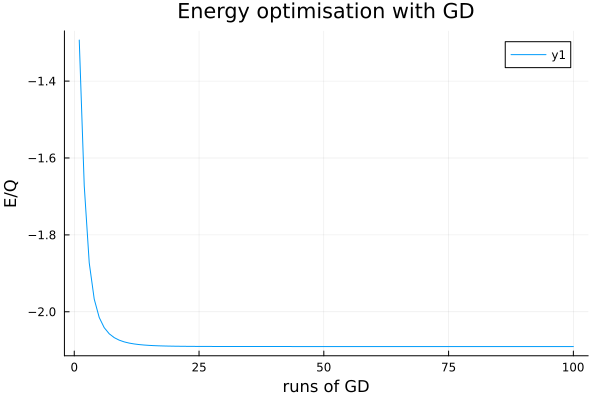

Optimized thetas: [0.1434289078978982, 0.1434289078978982, 0.1434289078978982, 1.332509615103727, 1.332509615103727, 1.332509615103727, 1.332509615103727, -0.10364647182116593, -0.10364647182116593, -0.10364647182116593, 0.922272101555106, 0.922272101555106, 0.922272101555106, 0.922272101555106]
Optimized energy: -2.090526816226526


In [52]:
opt_thetas_target, opt_energy_gd = target_optimization(ansatz; max_freq=30, max_weight=5, verbose = true);

### MCMC
Now that we have the alphas (eq 14) from the target circuit, we can run MCMC to get the set of classically efficiently simulable states $S_{\psi} =\{|\phi_i>\}$.

In [44]:
acc_samples, exact_energies_MCMC, acceptance_rates,repartition_MCMC,num_samples = MCMC(ansatz,opt_thetas_target;burn_in_samples =20,n_sweeps = 0,x_sigma = 0.1);

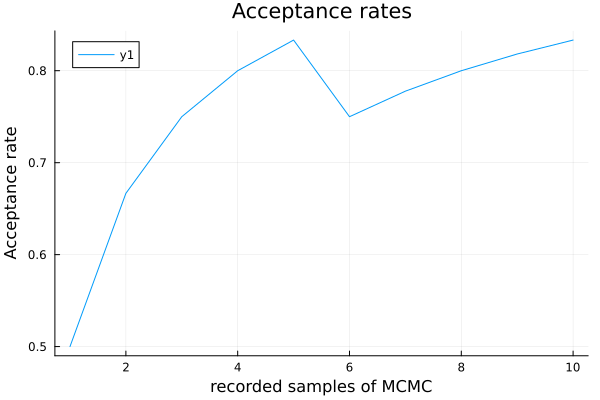

In [45]:
plot(acceptance_rates)
plot!(title = "Acceptance rates", xlabel = "recorded samples of MCMC", ylabel = "Acceptance rate")

### Noisy sample generation
- we have generated a set of classically efficiently simulable states $S_{\psi} =\{|\phi_i>\}$, so we now have our list of ground state energies and the corresponding circuits for the correction (i.e $X_{\phi_i}^{exact}$)
- there is no global noise model we can add to our training set, instead we add a layer of local depolarizing noise applied to all qubits individually  using the PP noise module to get our $X_{\phi_i}^{noisy}$

In [46]:
noisy_opt_energies = noisy_expectation_values(ansatz, acc_samples, repartition_MCMC;depol_strength = 0.05, dephase_strength = 0.05);

### Linear Model for Correction

10×2 DataFrame
 Row │ x         y        
     │ Float64   Float64  
─────┼────────────────────
   1 │ -1.85845  -2.05373
   2 │ -1.84333  -2.04292
   3 │ -1.81551  -2.03618
   4 │ -1.87842  -2.08116
   5 │ -1.86764  -2.06741
   6 │ -1.83731  -2.06023
   7 │ -1.88401  -2.08258
   8 │ -1.81424  -2.03419
   9 │ -1.86631  -2.07019
  10 │ -1.84361  -2.00043
Noisy target expectation value: -1.8867512385940273
Absolute error before CDR: 0.20377557763249876
CDR-EM target expectation value: -2.0792802930269447
Absolute error after CDR: 0.011246523199581304


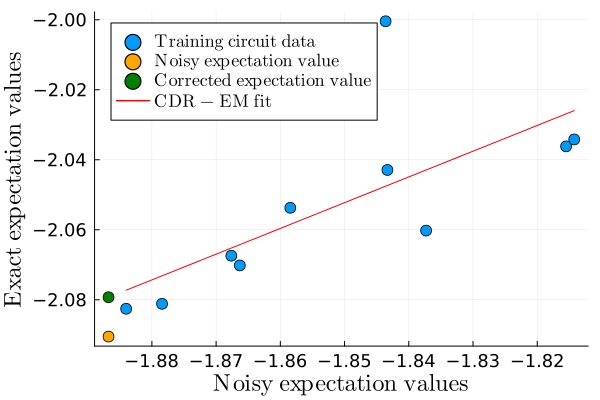

In [97]:
noisy_target_exp_value = noisy_expectation_values(ansatz, [ansatz.target_circuit], [ansatz.repartition],target = true)[1]
corr_energy, abs_err_before, abs_error_after = cdr(noisy_opt_energies, exact_energies_MCMC, noisy_target_exp_value, opt_energy_gd[end]; verbose = true);

# Tests on CDR

### Discussion of the results: 
For 4 qubits and 2 layers of the QAOA ansatz, this minimal example works.
We then scale up the system in the number of qubits.
The main limiting factor is the acceptance rate of the MCMC which we can increase by increasing the `npairs` value, as this gives us more distinct proposal circuits in case we started from a bad initialisation. The npairs value can be chosen at largest to be the `min(# of CLiffords, # of non-Cliffords)` . We can also set `x_sigma` higher as this broadens the probability distribution from which we sample via MCMC. \
Currently we use the PP noise model which can only provide local noise.
For higher noise levels, both the noisy and the exact expectation values cluster around some value as mentioned in Piotrs follow up paper. Already for our small example, we enforce clustering around the target value which in turn increases the number of shots needed to distinguish the noisy expectation values.

### System scaling test 
Now that the minimal example is working, we want to reproduce partially some results from the paper.
In Fig 3, we have: 
- a) Q=32, p=2 plotted vs. N (7,14,21,28,35)
- b) Q=16, N=28 plotted vs. p (1,2,3,4)
- c) p=2, N=28 plotted vs. Q (8,16,32,64)
- d) p=3, N=28 plotted vs Q (8,16,32,64)

Further parameters:
- the noise strength and type
- number of pairs changed by proposal circuit
- the number of qubits and layers
- the `x_sigma` in the acceptance ratio

We first start with a simple scaling of `nqubits`.

In [22]:
nqubits = 4:4:12
nlayers = 2
# plot the nqubits vs relative error
relative_errors_corrected = []
relative_errors_noisy = []
for nq in nqubits

    #target energies (we need the thetas from the target circuit)
    repartition_target = repartition_function_QAOA(nq,nlayers)
    ansatz = qaoa_setup(nq,nlayers,repartition_target)
    opt_thetas_target, opt_energy_gd = target_optimization(ansatz; max_freq=30, max_weight=5);
    println("Optimized energy for nq = ", nq," : ",opt_energy_gd[end])
    
    #MCMC
    acc_samples, exact_energies_MCMC, acceptance_rates,repartition_MCMC,num_samples = MCMC(ansatz,opt_thetas_target;npairs=nq, burn_in_samples = 50, n_sweeps = 0,x_sigma = 0.1);
    println("total samples needed: ", num_samples)
    
    #noisy expectation values and CDR
    noisy_opt_energies = noisy_expectation_values(ansatz, acc_samples, repartition_MCMC);
    noisy_target_exp_value = noisy_expectation_values(ansatz, [ansatz.target_circuit], [ansatz.repartition],target = true)[1]
    cdr_corrected_target, rel_error_after, rel_error_before = cdr(noisy_opt_energies, exact_energies_MCMC, noisy_target_exp_value, opt_energy_gd[end]);

    push!(relative_errors_corrected, rel_error_after)
    push!(relative_errors_noisy, rel_error_before)
end

Optimized energy for nq = 4 : -2.0877218153568746
total samples needed: 68
Optimized energy for nq = 8 : -2.1040256406712987
total samples needed: 66
Optimized energy for nq = 12 : -2.108324957766036
total samples needed: 61


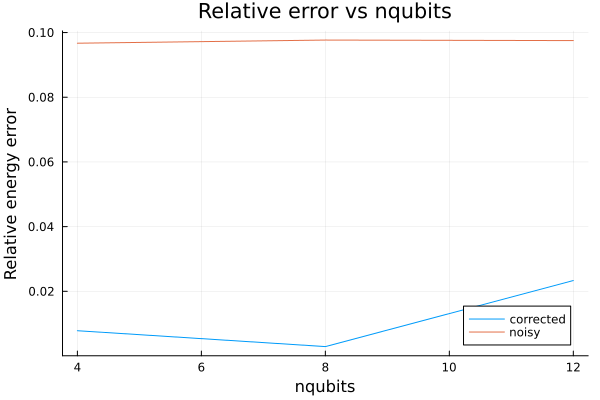

In [23]:
plot(nqubits, relative_errors_corrected, label = "corrected")
plot!(nqubits, relative_errors_noisy, label = "noisy")
plot!(title = "Relative error vs nqubits", xlabel = "nqubits", ylabel = "Relative energy error")

In [24]:
df = DataFrame(nqubits = nqubits, relative_errors_corrected = relative_errors_corrected, relative_errors_noisy = relative_errors_noisy)
CSV.write("nqubits_scale_test.csv", df)

"nqubits_scale_test.csv"

In [25]:
nqubits = 32
nlayers = 2
N = 7:7:35 #number of non-Clifford gates
list_num_gates_to_replace = (2*nqubits-1)*nlayers.-N

119:-7:91

### Fig 3a)
a) Q=32, p=2 plotted vs. N (7,14,21,28,35) -The MCMC takes too long here, even with high `x_sigma` and the highest `npairs`.

In [26]:
# nqubits = 32
# nlayers = 2
# N = 35 #28:7:35 #7:7:35 #number of non-Clifford gates
# list_num_gates_to_replace = (2*nqubits-1)*nlayers.-N
# relative_errors_corrected = []
# relative_errors_noisy = []
# opt_energies = []
# for replaced_gates in list_num_gates_to_replace
#     #make npairs as large as possible, here limited by the number of non-Cliffords
#     N = (2*nqubits-1)*nlayers - replaced_gates
#     #target energies (we need the thetas from the target circuit)
#     repartition_target = repartition_function_QAOA(nqubits,nlayers)
#     ansatz = qaoa_setup(nqubits,nlayers,repartition_target)
#     opt_thetas_target, opt_energy_gd = target_optimization(ansatz; max_freq=30, max_weight=5);
#     push!(opt_energies, opt_energy_gd[end])
#     println("Optimized energy for num of replaced gates ", replaced_gates," : ",opt_energy_gd[end])
    
#     #MCMC
#     acc_samples, exact_energies_MCMC, acceptance_rates,repartition_MCMC,i = MCMC(ansatz,opt_thetas_target;num_gates_to_replace = replaced_gates, npairs=N, burn_in_samples = 50, n_sweeps = 0,x_sigma = 0.5);
#     println("total samples needed: ", i)
    
#     #noisy expectation values and CDR
#     noisy_opt_energies = noisy_expectation_values(ansatz, acc_samples, repartition_MCMC;num_gates_to_replace = replaced_gates);
#     noisy_target_exp_value = noisy_expectation_values(ansatz, [ansatz.target_circuit], [ansatz.repartition],target = true)[1]
#     cdr_corrected_target, rel_error_after, rel_error_before = cdr(noisy_opt_energies, exact_energies_MCMC, noisy_target_exp_value, opt_energy_gd[end]);

#     push!(relative_errors_corrected, rel_error_after)
#     push!(relative_errors_noisy, rel_error_before)
# end

### Fig 3b)
 b) Q=16, N=28 plotted vs. p (1,2,3,4)

In [27]:
nqubits=16
N= 28 #non-Cliffords
nlayers = 1:1:2#4
relative_errors_corrected = []
relative_errors_noisy = []
opt_energies = []
for nl in nlayers

    #target energies (we need the thetas from the target circuit)
    repartition_target = repartition_function_QAOA(nqubits,nl)
    ansatz = qaoa_setup(nqubits,nl,repartition_target)
    opt_thetas_target, opt_energy_gd = target_optimization(ansatz; max_freq=30, max_weight=5);
    push!(opt_energies, opt_energy_gd[end])
    println("Optimized energy for nl = ", nl," : ",opt_energy_gd[end])
    
    # we choose as npairs the smaller value of CLiffords or non-CLifford gates 
    #MCMC
    acc_samples, exact_energies_MCMC, acceptance_rates,repartition_MCMC,i = MCMC(ansatz,opt_thetas_target;num_gates_to_replace = (2*nqubits-1)*nl-N, npairs=min(N,(2*nqubits-1)*nl-N), burn_in_samples = 50, n_sweeps = 0,x_sigma = 0.1);
    println("total samples needed: ", i)
    
    #noisy expectation values and CDR
    noisy_opt_energies = noisy_expectation_values(ansatz, acc_samples, repartition_MCMC;num_gates_to_replace = (2*nqubits-1)*nl-N);
    noisy_target_exp_value = noisy_expectation_values(ansatz, [ansatz.target_circuit], [ansatz.repartition],target = true)[1]
    cdr_corrected_target, rel_error_after, rel_error_before = cdr(noisy_opt_energies, exact_energies_MCMC, noisy_target_exp_value, opt_energy_gd[end]);

    push!(relative_errors_corrected, rel_error_after)
    push!(relative_errors_noisy, rel_error_before)
end

Optimized energy for nl = 1 : -2.1108856837721155
total samples needed: 62
Optimized energy for nl = 2 : -2.1106681556894555
total samples needed: 68


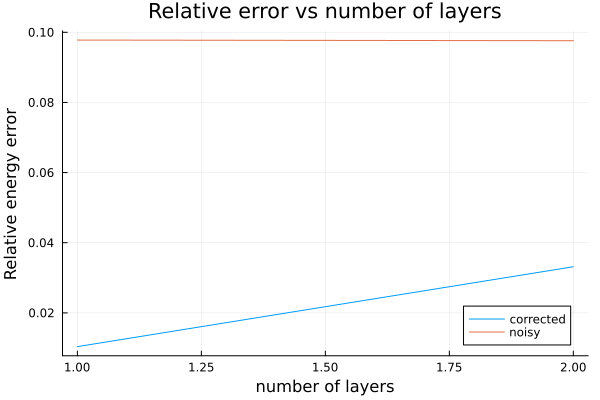

In [28]:
plot(nlayers, relative_errors_corrected, label = "corrected")
plot!(nlayers, relative_errors_noisy, label = "noisy")
#exp scaling y axis
plot!(title = "Relative error vs number of layers", xlabel = "number of layers", ylabel = "Relative energy error")

In [29]:
df = DataFrame(nlayers = nlayers, relative_errors_corrected = relative_errors_corrected, relative_errors_noisy = relative_errors_noisy,opt_energies = opt_energies)
CSV.write("Fig3b_CDR_reduced.csv", df)

"Fig3b_CDR_reduced.csv"